In [31]:
%matplotlib inline

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate


In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
import imageio
import matplotlib.pyplot as plt
import re
from PIL import Image

## 1. Load and split image data

#### MADOS to RGB and Mask

In [3]:
path = ''
image_path = os.path.join(path, 'data/CameraRGB/')
label_path = os.path.join(path, 'data/CameraMask_png/')

In [4]:
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list_orig = os.listdir(label_path)
mask_list = [label_path+i for i in mask_list_orig]

In [5]:
len(image_list), len(mask_list)

(2803, 2803)

In [6]:
image_list[0]

'data/CameraRGB/Scene_0_L2R_rgb_1.png'

In [5]:
def splitDataset():
    image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
    mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

    for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
        print(path)
        
    image_filenames = tf.constant(image_list)
    masks_filenames = tf.constant(mask_list)
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

    for image, mask in dataset.take(1):
        print(image)
        print(mask)
        
    return dataset

In [6]:
dataset = splitDataset()

(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\CameraRGB\\Scene_0_L2R_rgb_1.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\CameraMask_png\\Scene_0_L2R_cl_1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\CameraRGB\\Scene_0_L2R_rgb_2.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\CameraMask_png\\Scene_0_L2R_cl_2.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\CameraRGB\\Scene_0_L2R_rgb_3.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\CameraMask_png\\Scene_0_L2R_cl_3.png'>)
tf.Tensor(b'data/CameraRGB/Scene_0_L2R_rgb_1.png', shape=(), dtype=string)
tf.Tensor(b'data/CameraMask_png/Scene_0_L2R_cl_1.png', shape=(), dtype=string)


In [9]:
len(dataset)

2803

#### 1.2 - Preprosess the Data¶

In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

    return img, mask

# resize
def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

In [8]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
type(processed_image_ds)

In [9]:
class_names = ['Non-annotated',
        'Marine Debris',
        'Dense Sargassum',
        'Sparse Floating Algae',
        'Natural Organic Material',
        'Ship',
        'Oil Spill',
        'Marine Water',
        'Sediment-Laden Water',
        'Foam',
        'Turbid Water',
        'Shallow Water',
        'Waves and Wakes',
        'Oil Platform',
        'Jellyfish',
        'Sea snot']

In [10]:
BUFFER_SIZE = 500
BATCH_SIZE = 32
#train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#print(processed_image_ds.element_spec)

In [11]:
def split_dataset(image_ds, train_size=0.7, val_size=0.15, test_size=0.15):
    # Shuffle the dataset
    shuffled_ds = image_ds.shuffle(BUFFER_SIZE)

    # Ensure the split sizes sum to 1.0
    assert train_size + val_size + test_size == 1.0, "Sizes must sum to 1."

    # Count the total number of samples in the dataset
    total_samples = sum(1 for _ in shuffled_ds)

    # Calculate the split indices
    train_count = int(total_samples * train_size)
    val_count = int(total_samples * val_size)
    test_count = total_samples - train_count - val_count  # The rest is for test

    # Create the train, validation, and test datasets
    train_ds = shuffled_ds.take(train_count)
    val_ds = shuffled_ds.skip(train_count).take(val_count)
    test_ds = shuffled_ds.skip(train_count + val_count).take(test_count)

    # Apply batch size to the datasets
    train_batch = train_ds.batch(BATCH_SIZE)
    val_batch = val_ds.batch(BATCH_SIZE)
    test_batch = test_ds.batch(BATCH_SIZE)
    
    return train_ds, val_ds, test_ds, train_batch, val_batch, test_batch


train_dataset, val_dataset, test_dataset, train_bat, val_bat, test_bat = split_dataset(processed_image_ds)


In [12]:
print('train:',len(train_dataset))
print('val:',len(val_dataset))
print('test:',len(test_dataset))

train: 1962
val: 420
test: 421


## 2. Model (U-Net)

### 2.1 Encoder
* 2 Conv, MaxPooling, and dropout

In [38]:
# conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### 2.2 Decoder

In [39]:
#upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    
    return conv

### 2.3 U-Net

In [31]:
len(class_names)

16

In [40]:
# unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=16):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [41]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 96, 128, 32)  896         ['input_3[0][0]']                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_44[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_45[0][0]']        

                                                                                                  
Total params: 8,640,240
Trainable params: 8,640,240
Non-trainable params: 0
__________________________________________________________________________________________________


### UNet++

In [25]:
# Convolutional Block
def conv_block_pp(inputs, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D((2, 2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

# Upsampling Block
def upsampling_block_pp(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    
    contractive_input_resized = tf.image.resize(contractive_input, (tf.shape(up)[1], tf.shape(up)[2]))
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input_resized], axis=3)
    
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

# U-Net++ Model
def unet_plusplus(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)

    # Encoder Path (Contracting)
    c1, s1 = conv_block_pp(inputs, n_filters)
    c2, s2 = conv_block_pp(c1, n_filters*2)
    c3, s3 = conv_block_pp(c2, n_filters*4)
    c4, s4 = conv_block_pp(c3, n_filters*8)

    # Decoder Path (Expanding) with Skip Connections
    u4 = upsampling_block_pp(c4, s3, n_filters*4)
    u3 = upsampling_block_pp(u4, s2, n_filters*2)
    u2 = upsampling_block_pp(u3, s1, n_filters)

    # Nested skip pathways
    u3_ = upsampling_block_pp(u4, s2, n_filters*2)
    u2_ = upsampling_block_pp(u3_, s1, n_filters)
    u1_ = upsampling_block_pp(u2_, inputs, n_filters)

    # Final Conv to refine the output
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1_)

    # Output layer
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

# Instantiate and print model summary
unet_pp = unet_plusplus(input_size=(96, 128, 3), n_filters=32, n_classes=16)
unet_pp.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_22[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_23[0][0]']        

                                                                                                  
 conv2d_37 (Conv2D)             (None, 24, 32, 64)   36928       ['conv2d_36[0][0]']              
                                                                                                  
 conv2d_transpose_10 (Conv2DTra  (None, 48, 64, 32)  18464       ['conv2d_37[0][0]']              
 nspose)                                                                                          
                                                                                                  
 tf.compat.v1.shape_20 (TFOpLam  (4,)                0           ['conv2d_transpose_10[0][0]']    
 bda)                                                                                             
                                                                                                  
 tf.compat.v1.shape_21 (TFOpLam  (4,)                0           ['conv2d_transpose_10[0][0]']    
 bda)     

### 2.4 Loss function

In [90]:
# Focal Loss function
# Focal loss is particularly useful for class-imbalanced segmentation tasks,
# It reduces the relative loss for well-classified examples and focuses more on hard, misclassified examples.
def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification
    :param gamma: Focusing parameter. Default is 2.
    :param alpha: Weighting factor for the class. Default is 0.25.
    :return: Focal loss function
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Calculate cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Compute focal loss
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)

    return focal_loss_fixed

In [91]:
initial_learning_rate = 0.001

# Create an exponential decay function
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,  # Number of steps after which to apply decay
    decay_rate=0.96,   # Decay rate
    staircase=True      # Apply decay after each decay step
)

'''
# Compile the model with Adam optimizer and the learning rate schedule
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''


# Assuming you've already defined your U-Net model `unet_model`
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                   loss=focal_loss(gamma=2., alpha=0.25),
                   metrics=['accuracy'])


### Features
image pixel value : 0~15
* each pixel value shows the class of marine 15 features

class_names = ['Non-annotated','Marine Debris',' Dense Sargassum','Sparse Floating Algae',
        'Natural Organic Material','Ship', 'Oil Spill', 'Marine Water', 'Sediment-Laden Water',
        'Foam', 'Turbid Water','Shallow Water','Waves and Wakes','Oil Platform','Jellyfish','Sea snot']
        

### Expected result
* training accuracy is over 95%
* test accuracy is over 80%

### Hyperparameters of UNet
1. Batch size = 32
2. learning rate = 0.001 with decay
3. Optimization: Adam
4. Epoch: 10


### Hyperparameters of UNet++
1. Batch size = 32
2. learning rate = 0.001 with decay
3. Optimization: Adam
4. Epoch: 10


### Experiments version history
|version | | debug |
|----|----|--|
| v1.0 | UNet | analysis MADOS and use sample images |
| v2.0 | UNet | split MADOS as original image and mask image |
| v3.0 | UNet | sperate code data processing and model training |
| v4.0 | UNet, UNet++ | increase epoches, add UNet++ |


### 2.5 Train the Model

In [92]:
EPOCHS = 10
unet_history = unet.fit(train_bat, epochs=EPOCHS, validation_data=val_bat)

Epoch 1/10
62/62 [==============================] - 177s 3s/step - loss: 0.2078 - accuracy: 0.9905 - val_loss: 0.1580 - val_accuracy: 0.9916
Epoch 2/10
62/62 [==============================] - 186s 3s/step - loss: 0.1649 - accuracy: 0.9904 - val_loss: 0.1303 - val_accuracy: 0.9914
Epoch 3/10
62/62 [==============================] - 192s 3s/step - loss: 0.1463 - accuracy: 0.9902 - val_loss: 0.1124 - val_accuracy: 0.9920
Epoch 4/10
62/62 [==============================] - 183s 3s/step - loss: 0.1377 - accuracy: 0.9900 - val_loss: 0.1014 - val_accuracy: 0.9928
Epoch 5/10
62/62 [==============================] - 187s 3s/step - loss: 0.1264 - accuracy: 0.9903 - val_loss: 0.0812 - val_accuracy: 0.9929
Epoch 6/10
62/62 [==============================] - 219s 4s/step - loss: 0.1154 - accuracy: 0.9905 - val_loss: 0.1261 - val_accuracy: 0.9902
Epoch 7/10
62/62 [==============================] - 199s 3s/step - loss: 0.1199 - accuracy: 0.9902 - val_loss: 0.0923 - val_accuracy: 0.9923
Epoch 8/10
62

In [93]:
# Evaluate the model on the test data
test_loss, test_accuracy = unet.evaluate(test_bat)

print(f"UNet with focal loss Test Loss: {test_loss}")
print(f"UNet with focal loss Test Accuracy: {test_accuracy}")

14/14 [==============================] - 9s 538ms/step - loss: 0.1004 - accuracy: 0.9911
UNet with focal loss Test Loss: 0.1003713384270668
UNet with focal loss Test Accuracy: 0.9910914897918701


### 2.6 Plot Model Accuracy

#### 2.6.1 UNet with entropy loss

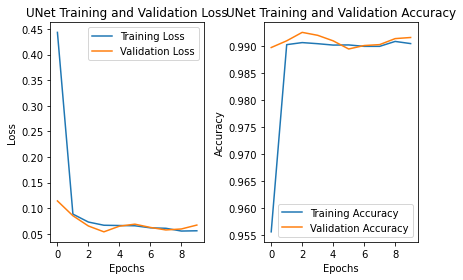

In [39]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(unet_history.history['loss'], label='Training Loss')
plt.plot(unet_history.history['val_loss'], label='Validation Loss')
plt.title('UNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(unet_history.history['accuracy'], label='Training Accuracy')
plt.plot(unet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('UNet Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

#### 2.6.2 UNet with focal loss

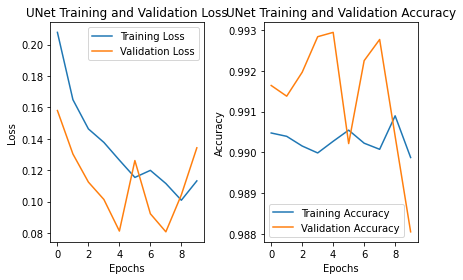

In [94]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(unet_history.history['loss'], label='Training Loss')
plt.plot(unet_history.history['val_loss'], label='Validation Loss')
plt.title('UNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(unet_history.history['accuracy'], label='Training Accuracy')
plt.plot(unet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('UNet Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### UNet++

In [27]:
initial_learning_rate = 0.001

# Create an exponential decay function
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,  # Number of steps after which to apply decay
    decay_rate=0.96,   # Decay rate
    staircase=True      # Apply decay after each decay step
)

# Compile the model with Adam optimizer and the learning rate schedule
unet_pp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [28]:
EPOCHS = 10
unet_pp_history = unet_pp.fit(train_bat, epochs=EPOCHS, validation_data=val_bat)

Epoch 1/10
62/62 [==============================] - 103s 2s/step - loss: 0.3061 - accuracy: 0.9494 - val_loss: 0.0917 - val_accuracy: 0.9898
Epoch 2/10
62/62 [==============================] - 102s 2s/step - loss: 0.0861 - accuracy: 0.9905 - val_loss: 0.0623 - val_accuracy: 0.9913
Epoch 3/10
62/62 [==============================] - 105s 2s/step - loss: 0.0661 - accuracy: 0.9908 - val_loss: 0.0618 - val_accuracy: 0.9926
Epoch 4/10
62/62 [==============================] - 102s 2s/step - loss: 0.0656 - accuracy: 0.9905 - val_loss: 0.0603 - val_accuracy: 0.9920
Epoch 5/10
62/62 [==============================] - 104s 2s/step - loss: 0.0602 - accuracy: 0.9908 - val_loss: 0.0659 - val_accuracy: 0.9907
Epoch 6/10
62/62 [==============================] - 105s 2s/step - loss: 0.0632 - accuracy: 0.9904 - val_loss: 0.0517 - val_accuracy: 0.9931
Epoch 7/10
62/62 [==============================] - 105s 2s/step - loss: 0.0627 - accuracy: 0.9906 - val_loss: 0.0620 - val_accuracy: 0.9915
Epoch 8/10
62

In [44]:
# Evaluate the model on the test data
test_loss, test_accuracy = unet_pp.evaluate(test_bat)

print(f"UNet++ Test Loss: {test_loss}")
print(f"UNet++ Test Accuracy: {test_accuracy}")

14/14 [==============================] - 5s 291ms/step - loss: 0.0462 - accuracy: 0.9936
UNet++ Test Loss: 0.04619475081562996
UNet++ Test Accuracy: 0.9935545325279236


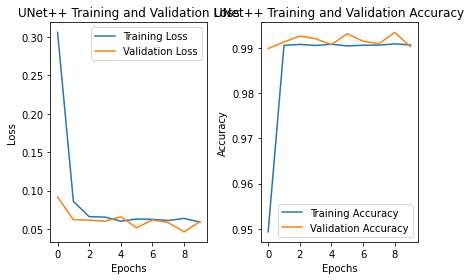

In [29]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(unet_pp_history.history['loss'], label='Training Loss')
plt.plot(unet_pp_history.history['val_loss'], label='Validation Loss')
plt.title('UNet++ Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(unet_pp_history.history['accuracy'], label='Training Accuracy')
plt.plot(unet_pp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('UNet++ Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### 2.7 Save and load model

In [62]:
# Save UNet
unet.save('save/unet_model')

INFO:tensorflow:Assets written to: save/model\assets


INFO:tensorflow:Assets written to: save/model\assets


In [95]:
# Save UNet
unet.save('save/unet_focal_model')

INFO:tensorflow:Assets written to: save/unet_focal_model\assets


INFO:tensorflow:Assets written to: save/unet_focal_model\assets


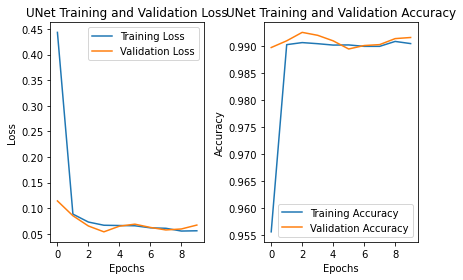

In [39]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(unet_history.history['loss'], label='Training Loss')
plt.plot(unet_history.history['val_loss'], label='Validation Loss')
plt.title('UNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(unet_history.history['accuracy'], label='Training Accuracy')
plt.plot(unet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('UNet Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [78]:
#load UNet 
unet = tf.keras.models.load_model('save/unet_model')
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 96, 128, 32)  896         ['input_3[0][0]']                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_28[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_29[0][0]']        

                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


In [30]:
# Save UNet++
unet_pp.save('save/unetpp_model')

INFO:tensorflow:Assets written to: save/unetpp_model\assets


INFO:tensorflow:Assets written to: save/unetpp_model\assets


In [31]:
#load UNet++
unet_pp = tf.keras.models.load_model('save/unetpp_model')
unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_22[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_23[0][0]']        

                                                                                                  
 conv2d_37 (Conv2D)             (None, 24, 32, 64)   36928       ['conv2d_36[0][0]']              
                                                                                                  
 conv2d_transpose_10 (Conv2DTra  (None, 48, 64, 32)  18464       ['conv2d_37[0][0]']              
 nspose)                                                                                          
                                                                                                  
 tf.compat.v1.shape_20 (TFOpLam  (4,)                0           ['conv2d_transpose_10[0][0]']    
 bda)                                                                                             
                                                                                                  
 tf.compat.v1.shape_21 (TFOpLam  (4,)                0           ['conv2d_transpose_10[0][0]']    
 bda)     

### 2.6 Test

In [32]:
def display(display_list, class_number):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(f'{title[i]},{class_names[class_number]}')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [33]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [99]:
def get_label(mask):
    # Count number of non-zero pixels in the mask (non-background regions)
    mask_flat = mask.flatten()
    # Calculate the histogram
    unique_values, counts = np.unique(mask_flat, return_counts=True)

    positive_unique_values = np.abs(unique_values).astype(int)
    '''
    # Get the indices that would sort unique_values
    sorted_indices = np.argsort(positive_unique_values)

    # Sort unique_values and counts based on the sorted indices
    sorted_unique_values = unique_values[sorted_indices]
    sorted_counts = counts[sorted_indices]
    
    # Display the sorted results
    print("Sorted Unique Values:", sorted_unique_values)
    print("Sorted Counts:", sorted_counts)    
    '''
    # Find the index of the maximum count
    max_count_index = np.argmax(counts)


    # Get the unique value with the maximum count
    max_count_value = positive_unique_values[max_count_index]
    max_count = counts[max_count_index]
    #print('label:',max_count_value,max_count, class_name[max_count_value])#, class_name[unique_values])
    return positive_unique_values, counts

In [35]:
def show_predictions(model,dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            label_numbers, counts = get_label(pred_mask)
            print(label_numbers[0])
            display([image[0], mask[0], create_mask(pred_mask)], label_numbers[0])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

### UNet Test

1/1 [==============================] - 1s 584ms/step
5417


IndexError: list index out of range

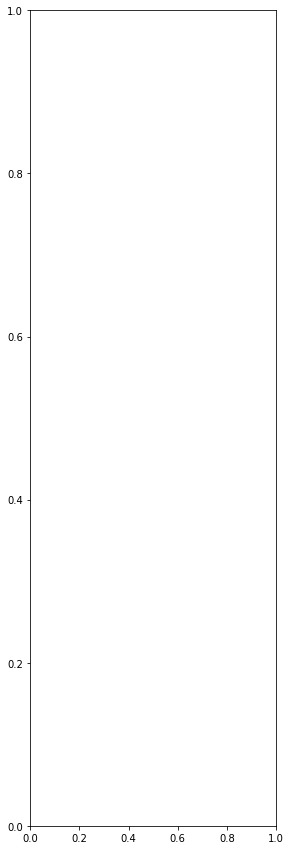

In [100]:
# unet with focal loss
show_predictions(unet,test_bat, 6)

1/1 [==============================] - 0s 290ms/step
Sorted Unique Values: [-0.7942847   0.28637427  0.28637528 ... 12.645417   12.160173
 12.686499  ]
Sorted Counts: [1 2 1 ... 1 1 1]
9


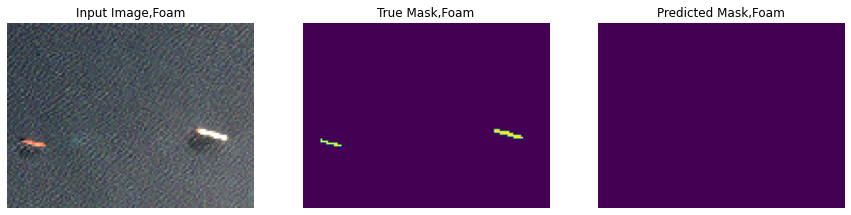

1/1 [==============================] - 0s 288ms/step
Sorted Unique Values: [-0.8341911   0.29894888  0.298949   ...  9.177705    9.178534
  9.320475  ]
Sorted Counts: [1 1 1 ... 1 1 1]
6


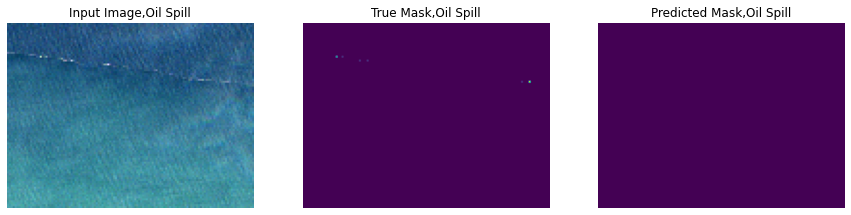

1/1 [==============================] - 0s 283ms/step
Sorted Unique Values: [-0.85504067  0.3000973   0.30009738 ...  9.099679    9.215986
  9.237832  ]
Sorted Counts: [1 1 1 ... 1 1 1]
6


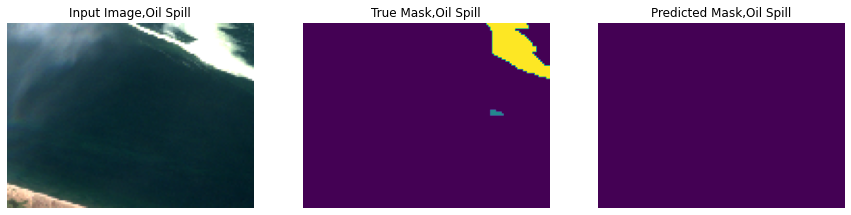

1/1 [==============================] - 0s 289ms/step
Sorted Unique Values: [-0.76400954  0.24277107  0.24277113 ...  9.141563    9.252343
  9.374696  ]
Sorted Counts: [1 1 1 ... 1 1 1]
6


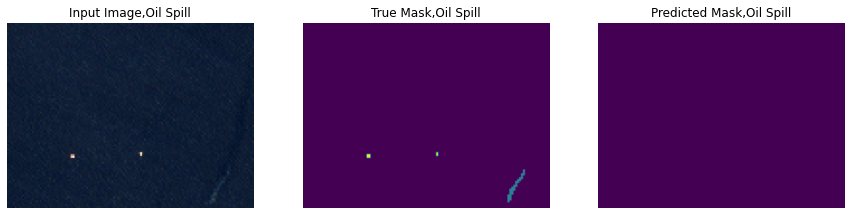

1/1 [==============================] - 0s 285ms/step
Sorted Unique Values: [-0.83490556  0.29097816  0.29097885 ...  9.119267    9.133222
  9.267951  ]
Sorted Counts: [1 2 1 ... 1 1 1]
6


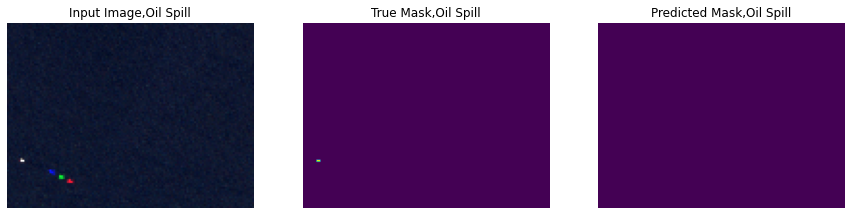

1/1 [==============================] - 0s 287ms/step
Sorted Unique Values: [-0.8758824   0.30763865  0.30763882 ... 12.125308   12.0887785
 12.407675  ]
Sorted Counts: [1 1 1 ... 1 1 1]
8


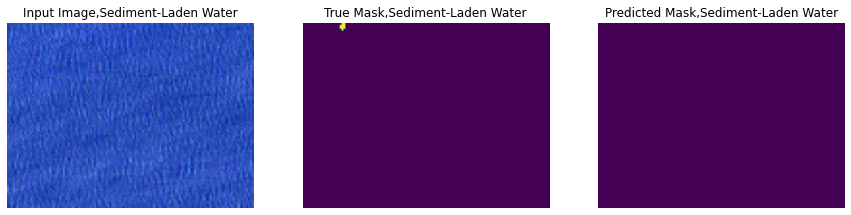

In [76]:
show_predictions(unet_pp,test_bat, 6)

In [73]:
def display2(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [74]:
def show_predictions2(model,dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display2([image[0], mask[0], create_mask(pred_mask)])
    else:
        display2([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 284ms/step


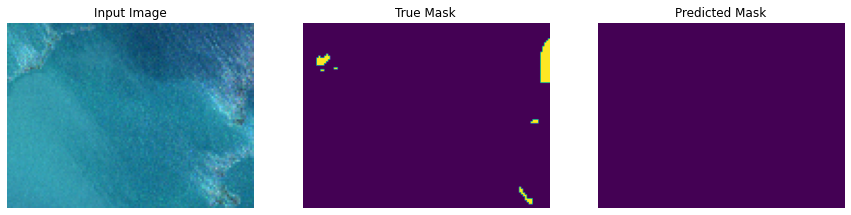

1/1 [==============================] - 0s 281ms/step


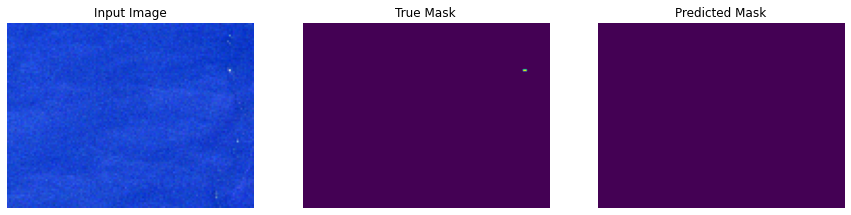

1/1 [==============================] - 0s 285ms/step


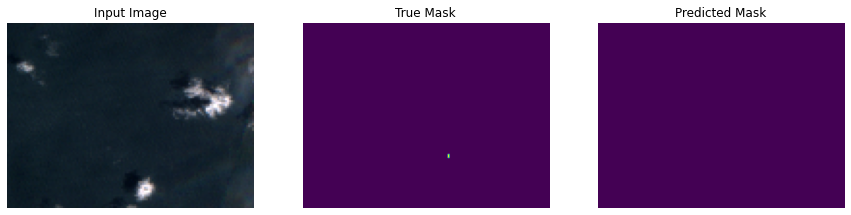

1/1 [==============================] - 0s 272ms/step


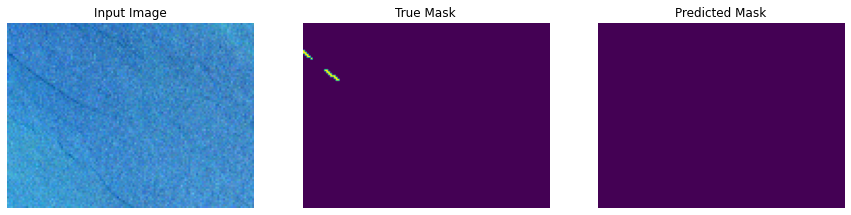

1/1 [==============================] - 0s 282ms/step


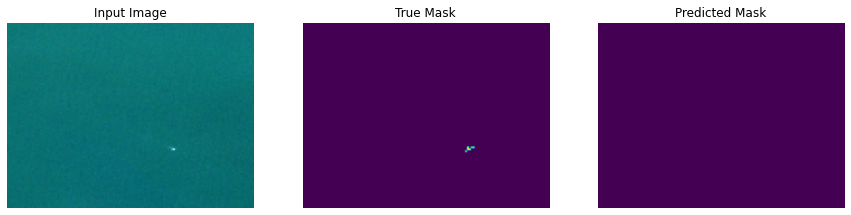

1/1 [==============================] - 0s 294ms/step


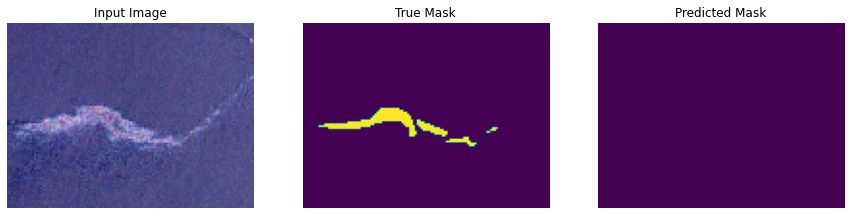

In [75]:
show_predictions2(unet_pp,test_bat, 6)

In [1]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

def iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union
